In [428]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from IPython.display import Audio

import schemdraw
from schemdraw import dsp
import schemdraw.elements as e

from IPython.core.display import HTML
HTML(r"""
<style>
    .jp-MarkdownCell .jp-RenderedHTMLCommon {
        font-family: "Times New Roman", Times, serif;
        font-size: 20px
    }
</style>
""")

In [421]:
fs = 44100
t = np.arange(0, 3, 1/fs)
x = 0.3 * np.sin(2 * np.pi * 1000 * t) + 0.6 * np.sin(2 * np.pi * 2000 * t)
noise = 0.2 * np.random.randn(len(t))
sig = x + noise
Audio(data = sig * 0.1, rate = fs)

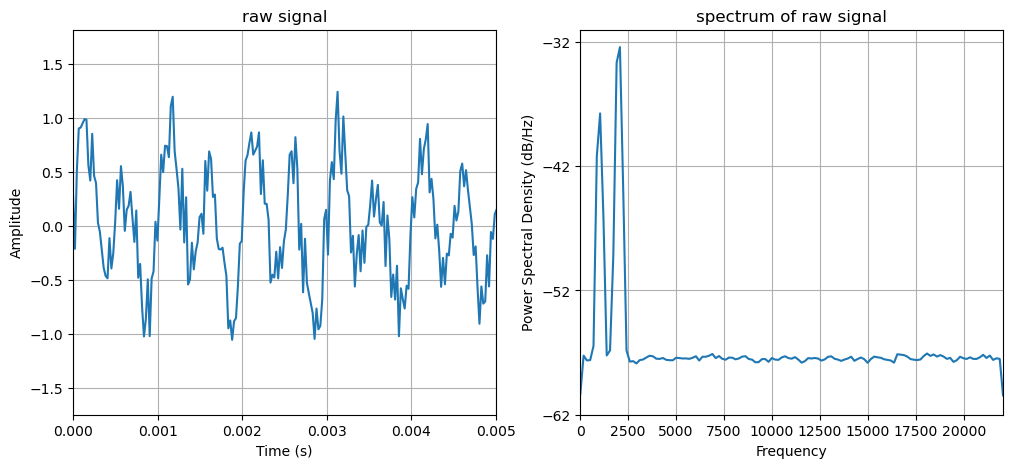

In [433]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(t, sig)
plt.xlim(0, 0.005)
plt.title('raw signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(which='both', axis='both')

plt.subplot(1, 2, 2)
plt.psd(sig, Fs=fs)
plt.title('spectrum of raw signal')
plt.xlim(0, fs / 2)

plt.show()

## FIR filter (compare to convolution)

In [383]:
cutoff_freq = 3000
filter_order = 20
fir_coef = signal.firwin(filter_order, cutoff=cutoff_freq, fs=fs)

sig_FIR = signal.lfilter(fir_coef, 1, sig) # apply FIR filter
sig_conv = np.convolve(sig, fir_coef, mode='same') # using convolution

## IIR filter

https://www.samproell.io/posts/yarppg/digital-filters-python/

In [409]:
b, a = signal.butter(4, cutoff_freq, btype='low', fs=fs)
sig_IIR = signal.lfilter(b, a, sig)

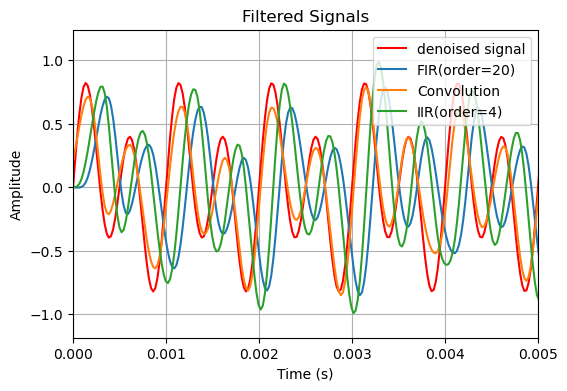

In [438]:
plt.figure(figsize=(6, 4))
plt.plot(t, x, label = 'denoised signal', color='red')
plt.plot(t, sig_FIR, label = 'FIR(order=20)')
plt.plot(t, sig_conv, label = 'Convolution')
plt.plot(t, sig_IIR, label = 'IIR(order=4)')
plt.xlim(0, 0.005)
plt.title('Filtered Signals')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(which='both', axis='both')
plt.legend(loc='upper right')
plt.show()

We can observe group delay when implementing both FIR and IIR filters. A fourth-order IIR filter can achieve a comparable, or even superior, effect to that of a 20th-order FIR filter, indicating that IIR filters are more efficient than FIR filters.

([group delay](https://circuitcellar.com/research-design-hub/group-delay-basics-more-filter-fun/#:~:text=Linear%2Dphase%20filters%20delay%20the,varies%20linearly%20with%20the%20frequency.))

In [439]:
Audio(data = sig_FIR * 0.1, rate = fs)

In [440]:
Audio(data = sig_conv * 0.1, rate = fs)

In [441]:
Audio(data = sig_IIR * 0.1, rate = fs)

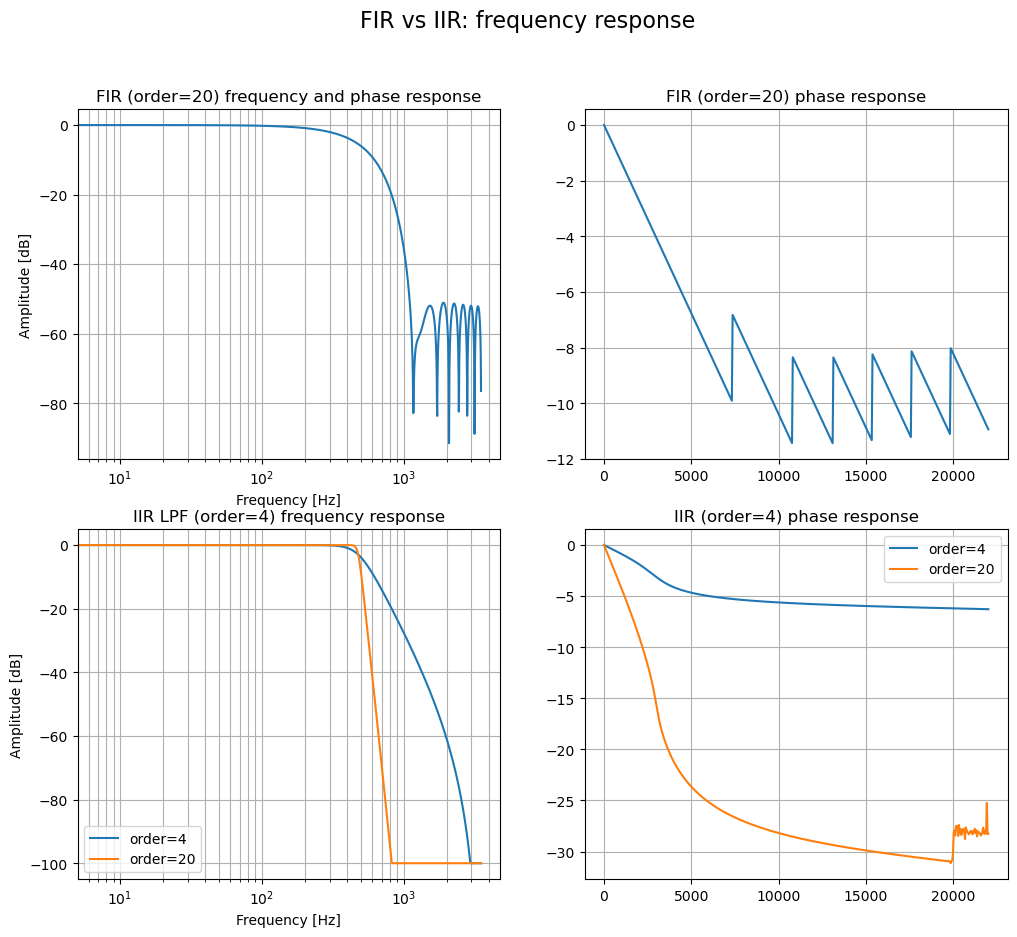

In [450]:
w_FIR, h_FIR = signal.freqz(fir_coef, 1, fs=fs)
w_IIR, h_IIR = signal.freqz(b, a, fs=fs)

b20, a20 = signal.butter(20, cutoff_freq, btype='low', fs=fs)
w_IIR20, h_IIR20 = signal.freqz(b20, a20, fs=fs)

plt.figure(figsize=(12, 10))
plt.suptitle('FIR vs IIR: frequency response', fontsize=16)
plt.subplot(2, 2, 1)
plt.semilogx(w_FIR / (2*np.pi), 20 * np.log10(abs(h_FIR)))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('FIR (order=20) frequency and phase response')
plt.grid(which='both', axis='both')

plt.subplot(2, 2, 2)
plt.plot(w_FIR , np.unwrap(np.angle(h_FIR)))
plt.title('FIR (order=20) phase response')
plt.grid(which='both', axis='both')

plt.subplot(2, 2, 3)
plt.semilogx(w_IIR / (2*np.pi), 20 * np.log10(np.maximum(abs(h_IIR), 1e-5)), label='order=4')
plt.semilogx(w_IIR20 / (2*np.pi), 20 * np.log10(np.maximum(abs(h_IIR20), 1e-5)), label='order=20')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('IIR LPF (order=4) frequency response')
plt.grid(which='both', axis='both')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(w_IIR , np.unwrap(np.angle(h_IIR)), label='order=4')
plt.plot(w_IIR20 , np.unwrap(np.angle(h_IIR20)), label='order=20')
plt.title('IIR (order=4) phase response')
plt.grid(which='both', axis='both')
plt.legend()

FIR requires a higher number of coefficients to match the attenuation characteristics of the IIR.
The phase spectrum of the IIR filter is non-linear in the passband (0 -> 3000 Hz) and becomes very non-linear at the cut-off frequency (3000).

[Difference between IIR and FIR filters](https://www.advsolned.com/difference-between-iir-and-fir-filters-a-practical-design-guide/)

# Comb filter

## Comb filter - feedforward

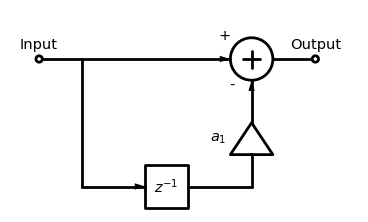

In [490]:
d = schemdraw.Drawing(fontsize = 12)
d.add(e.DOT_OPEN, label='Input')
Y = d.add(dsp.LINE, d='right', l=1)
d.add(dsp.LINE, d = 'down', l = 3)
d.add(dsp.LINE, d = 'right', l = 1.5)
d.add(dsp.ARROWHEAD, d='right')

d.add(dsp.BOX, label = '$z^{-1}$')
d.add(dsp.LINE, d = 'right', l = 1.5)
d.add(dsp.LINE, d = 'up', l = 0.75)
d.add(dsp.AMP, toplabel = '$a_1$')
d.add(dsp.LINE, d = 'up', l = 1)
d.add(dsp.ARROWHEAD, d='up', toplabel = '-')

d.add(dsp.LINE, d = 'right', xy = Y.end, l = 3.5)
d.add(dsp.ARROWHEAD, d='right', toplabel = '+')
SUM = d.add(dsp.SUM)
d.add(dsp.LINE, d = 'right', l = 1)
d.add(e.DOT_OPEN, label = 'Output')

d.draw()


<b>y[n] = x[n] + a * x[n-k]</b>

In [324]:
def ff_combFilter(signal, delay, gain):
    sig_ff = np.zeros(len(signal))

    for n in range(len(signal)):
        if n >= delay:
            sig_ff[n] = signal[n] + gain * sig_ff[n - delay]
        else:
            sig_ff[n] = signal[n]
    return sig_ff

In [325]:
sig_ffComb1 = ff_combFilter(sig, 5, 0.8)
Audio(data = sig_ffComb1 * 0.1, rate = fs)

In [326]:
sig_ffComb2 = ff_combFilter(sig, 5, -0.8)
Audio(data = sig_ffComb2 * 0.1, rate = fs)

In [336]:
sig_ffComb3 = ff_combFilter(sig, 20, 0.8)
Audio(data = sig_ffComb3 * 0.1, rate = fs)

In [337]:
sig_ffComb4 = ff_combFilter(sig, 20, -0.8)
Audio(data = sig_ffComb4 * 0.1, rate = fs)

(0.0, 22050.0)

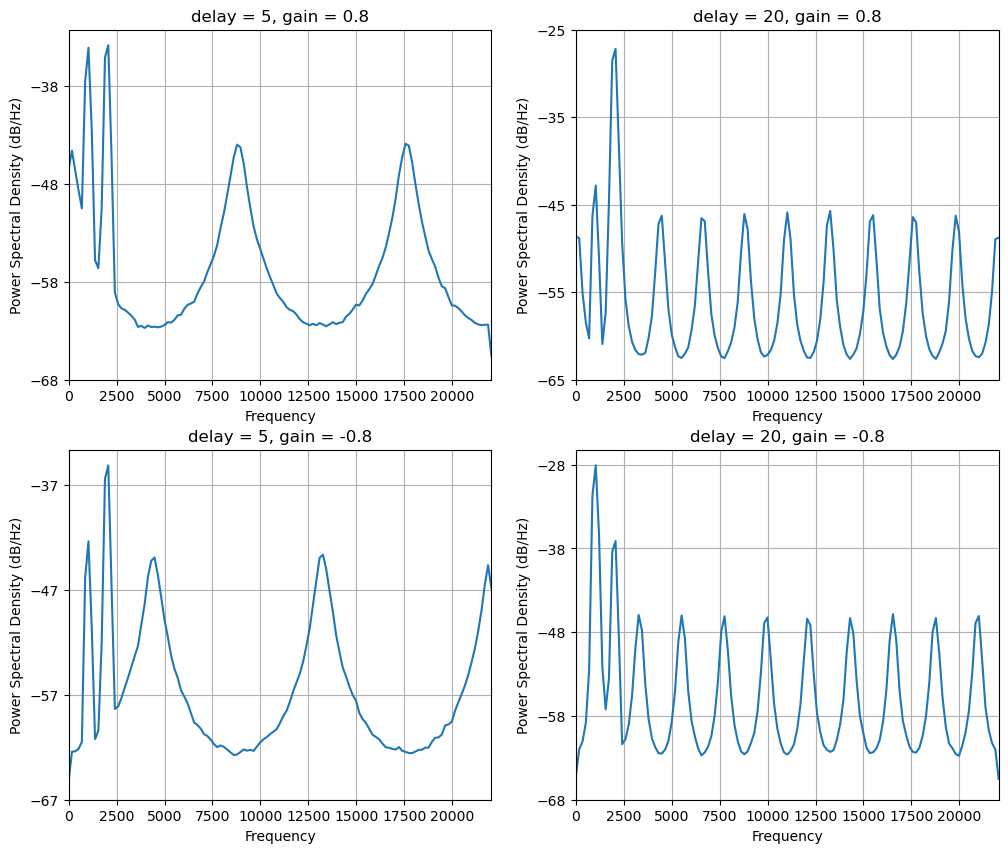

In [451]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.psd(sig_ffComb1, Fs=fs)
plt.title('delay = 5, gain = 0.8')
plt.xlim(0, fs / 2)

plt.subplot(2, 2, 2)
plt.psd(sig_ffComb3, Fs=fs)
plt.title('delay = 20, gain = 0.8')
plt.xlim(0, fs / 2)


plt.subplot(2, 2, 3)
plt.psd(sig_ffComb2, Fs=fs)
plt.title('delay = 5, gain = -0.8')
plt.xlim(0, fs / 2)

plt.subplot(2, 2, 4)
plt.psd(sig_ffComb4, Fs=fs)
plt.title('delay = 20, gain = -0.8')
plt.xlim(0, fs / 2)


## Comb Filter - feedback

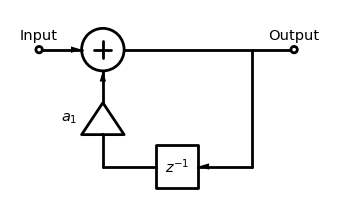

In [297]:
d = schemdraw.Drawing(fontsize = 12)
d.add(e.DOT_OPEN, label='Input', color='black')
L1 = d.add(dsp.LINE, d='right', l=1)
d.add(dsp.ARROWHEAD, d='right', color='black')
SUM0 = d.add(dsp.SUM, color = 'black')
Y = d.add(dsp.LINE, d = 'right', xy = SUM0.E, l = 3, color = 'black')
d.add(dsp.LINE, d = 'down', l = 2.75, color = 'black')
d.add(dsp.LINE, d = 'left', l = 1.25)
d.add(dsp.ARROWHEAD, d='left')
d.add(dsp.BOX, label = '$z^{-1}$')
d.add(dsp.LINE, d='left', l=1.25)
d.add(dsp.LINE, d='up', l=0.75)
A1 = d.add(dsp.AMP, toplabel = '$a_1$')
d.add(dsp.LINE, d = 'up', l = 0.75)
d.add(dsp.ARROWHEAD, d = 'up')

d.add(dsp.LINE, xy = Y.end, d = 'right', l = 1)
d.add(e.DOT_OPEN, label = 'Output')

d.draw()


<b>y[n] = x[n] + a * y[n-k]</b>

In [310]:
def fb_combFilter(signal, delay, gain):
    sig_fb = np.zeros(len(signal))

    for n in range(len(signal)):
        if n >= delay:
            sig_fb[n] = signal[n] + gain * signal[n - delay]
        else:
            sig_fb[n] = signal[n]
    return sig_fb

In [317]:
sig_fbComb1 = fb_combFilter(sig, 5, 0.8)
Audio(data = sig_fbComb1 * 0.1, rate = fs)

In [318]:
sig_fbComb2 = fb_combFilter(sig, 5, -0.8)
Audio(data = sig_fbComb2 * 0.1, rate = fs)

In [321]:
sig_fbComb3 = fb_combFilter(sig, 20, 0.8)
Audio(data = sig_fbComb3 * 0.1, rate = fs)

In [322]:
sig_fbComb4 = fb_combFilter(sig, 20, -0.8)
Audio(data = sig_fbComb4 * 0.1, rate = fs)

(0.0, 22050.0)

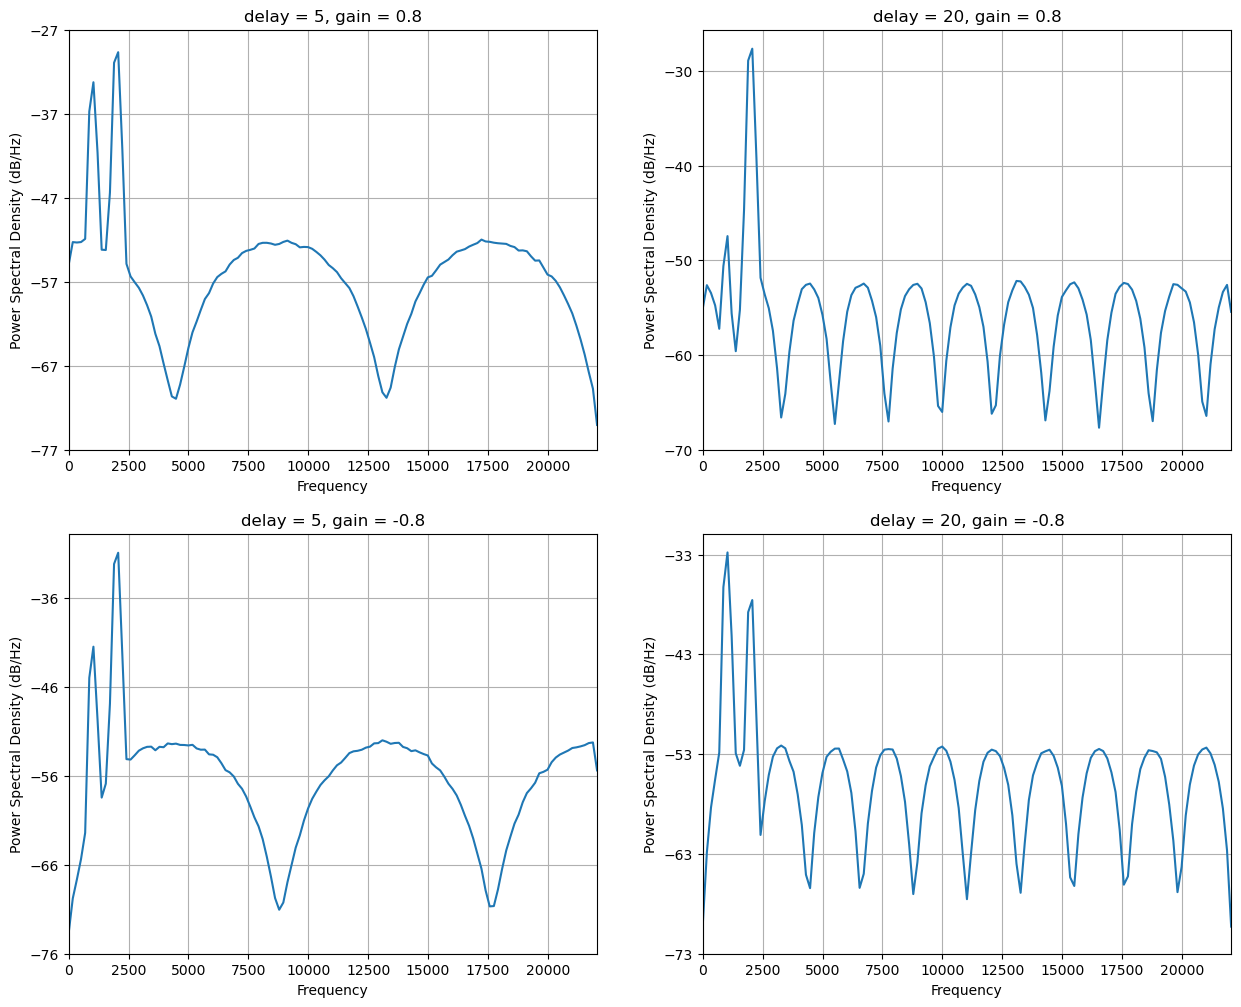

In [334]:
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.psd(sig_fbComb1, Fs=fs)
plt.title('delay = 5, gain = 0.8')
plt.xlim(0, fs / 2)

plt.subplot(2, 2, 2)
plt.psd(sig_fbComb3, Fs=fs)
plt.title('delay = 20, gain = 0.8')
plt.xlim(0, fs / 2)


plt.subplot(2, 2, 3)
plt.psd(sig_fbComb2, Fs=fs)
plt.title('delay = 5, gain = -0.8')
plt.xlim(0, fs / 2)

plt.subplot(2, 2, 4)
plt.psd(sig_fbComb4, Fs=fs)
plt.title('delay = 20, gain = -0.8')
plt.xlim(0, fs / 2)


(0.0, 22050.0)

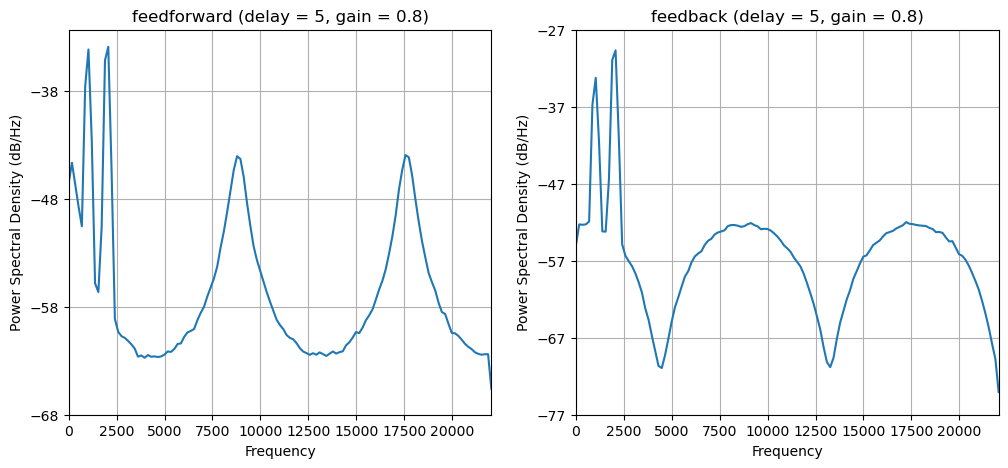

In [341]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.psd(sig_ffComb1, Fs=fs)
plt.title('feedforward (delay = 5, gain = 0.8)')
plt.xlim(0, fs / 2)

plt.subplot(1, 2, 2)
plt.psd(sig_fbComb1, Fs=fs)
plt.title('feedback (delay = 5, gain = 0.8)')
plt.xlim(0, fs / 2)

# Allpass filter

First-order allpass filter

- transfer function
$$
A(z) = \frac{a_1 + z^{-1}}{1+ a_1 z^{-1}}
$$

In [352]:
def firstOrderAPF(signal, gain):
    sig_AP = np.zeros(len(signal))

    for n in range(len(signal)):
        if n == 0:
            sig_AP[n] = signal[n]
        else:
            sig_AP[n] = gain * signal[n] + signal[n-1] - gain * sig_AP[n-1]

    return sig_AP

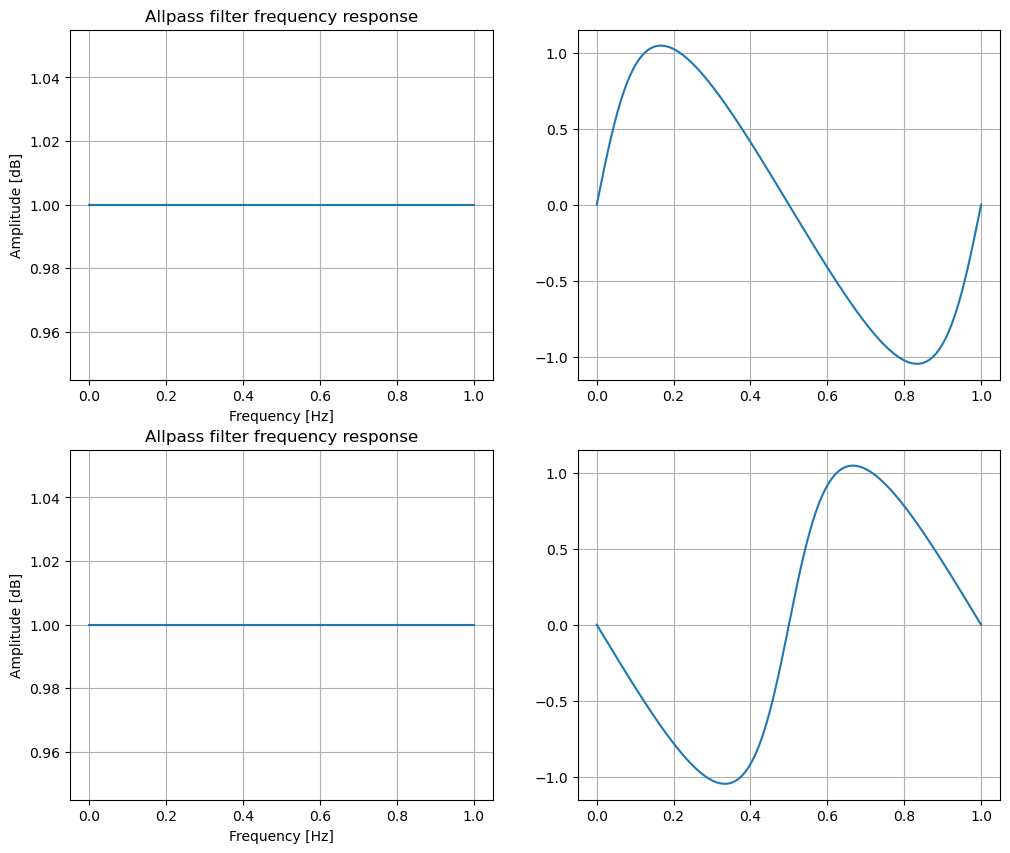

In [453]:
gain = 0.5
w = np.linspace(0, 2 * np.pi, 1000)
H1 = (1 - gain * np.exp(-1j * w)) / (1 - gain * np.exp(1j * w))
H2 = (1 + gain * np.exp(-1j * w)) / (1 + gain * np.exp(1j * w))

plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(w / (2*np.pi), np.abs(H1))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('APF frequency response')
plt.grid(which='both', axis='both')

plt.subplot(2, 2, 3)
plt.plot(w / (2*np.pi), np.abs(H1))
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
plt.title('APF frequency response')
plt.grid(which='both', axis='both')

plt.subplot(2, 2, 2)
plt.plot(w / (2*np.pi) , np.unwrap(np.angle(H1)), label='order=4')

plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(w / (2*np.pi) , np.unwrap(np.angle(H2)), label='order=4')
plt.grid(True)


# code references

- https://scipy-cookbook.readthedocs.io/items/FIRFilter.html
- https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.freqz.html
- https://scipy-cookbook.readthedocs.io/items/ApplyFIRFilter.html
- https://www.samproell.io/posts/yarppg/digital-filters-python/
- https://medium.com/@coolkaustubh13/comb-filter-implementation-60212c40b391
- https://github.com/shun60s/Peaking-Filter/blob/master/iir_HighShelving1.py